In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb

In [10]:
from src import TimeSeriesLSTM

In [11]:
#  confoguration for wandb
run = wandb.init(
    project='Water-Demand-Forecasting',
    notes='Testing out wandb',
)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [12]:

wandb.config = {
    'model_name':'LSTM_tests_101',
    'log_loss_interval':1,
    'save_path':r'model_saves',
    'save_model_interval':25,       
    'target_feature':'DMA A (L/s)',
    'include_historic_target':True,
    'historic_features':['Rainfall depth (mm)',	'Air temperature (°C)',	'Air humidity (%)',	'Windspeed (km/h)'	,'IsWeekend',	'Hour'],
    'future_features':['Rainfall depth (mm)',	'Air temperature (°C)',	'Air humidity (%)',	'Windspeed (km/h)'	,'IsWeekend',	'Hour'],
    'scaler_dict' : {'DMA A (L/s)': 'normalization', 'Air temperature (°C)': 'normalization', 'Air humidity (%)': 'normalization', 'Windspeed (km/h)': 'normalization', 'Rainfall depth (mm)': 'normalization', 'IsWeekend': 'normalization', 'Hour': 'normalization'},
    'historic_sequence_length':24*7,
    'prediction_horizon_length':24*7,
    'batch_size':32,
    'epochs':100,
    'learning_rate':0.001,
    'loss_function':'MultiQuantileLoss',
    'quantiles': [0.2, 0.5, 0.8],
    'masked_loss': True,
    'lstm_encoder_decoder_hidden_size':64,
    'lstm_encoder_layers':2,
    'lstm_encoder_dropout':0.2,
    'lstm_decoder_layers':2,
    'lstm_decoder_dropout':0.2,
}

In [13]:
# load excel files from ../data/raw/WDSA into a pandas dataframe, col 0 Date-time CET-CEST (DD/MM/YYYY HH:mm)
df_inflow = pd.read_excel(r'data/raw/WDSA/InflowData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')
df_weather = pd.read_excel(r'data/raw/WDSA/WeatherData_1.xlsx', index_col=0, parse_dates=True, date_format='%d/%m/%Y %H:%M')

# get latest start date of both datasets
start_date = max(df_inflow.index.min(), df_weather.index.min())

# get earliest end date of both datasets
end_date = min(df_inflow.index.max(), df_weather.index.max())

# get the intersection of both datasets
df_inflow = df_inflow.loc[start_date:end_date]
df_weather = df_weather.loc[start_date:end_date]

# add binary column to df_weather that indicates if it is weekend or midweek, make sure it is an integer
df_weather['IsWeekend'] = (df_weather.index.dayofweek > 4).astype(float)

# add hour of the day as a column to both dataframes
df_weather['Hour'] = df_weather.index.hour.astype(float)

# divide into first 75% training and 25% validation
divider = int(len(df_inflow) * 0.75)
df_inflow_train = df_inflow.iloc[:divider]
df_inflow_val = df_inflow.iloc[divider:]
df_weather_train = df_weather.iloc[:divider]
df_weather_val = df_weather.iloc[divider:]

# merge datasets
df_train = pd.merge(df_inflow_train, df_weather_train, left_index=True, right_index=True)
df_train = df_train.interpolate(method='linear')

df_val = pd.merge(df_inflow_val, df_weather_val, left_index=True, right_index=True)
df_val_interpolated = df_val.interpolate(method='linear')

In [14]:
df_train

,DMA A (L/s),DMA B (L/s),DMA C (L/s),DMA D (L/s),DMA E (L/s),DMA F (L/s),DMA G (L/s),DMA H (L/s),DMA I (L/s),DMA J (L/s),Rainfall depth (mm),Air temperature (°C),Air humidity (%),Windspeed (km/h),IsWeekend,Hour
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,,,,,,,,,,,,,,
2021-02-14 20:00:00,7.7800,9.9550,5.3500,40.6325,93.3300,9.3350,26.3525,22.6350,18.9875,25.3200,0.0,4.7,34.0,13.0,1.0,20.0
2021-02-14 21:00:00,7.1800,9.2800,4.8775,34.8850,83.8825,7.0250,21.7875,19.4700,18.9200,23.6500,0.0,4.0,42.0,19.0,1.0,21.0
2021-02-14 22:00:00,6.0825,9.0275,4.3500,30.2525,76.7000,7.6550,19.3600,16.9900,18.4250,22.8900,0.0,3.7,41.0,27.0,1.0,22.0
2021-02-14 23:00:00,5.2475,8.4900,3.9825,27.4275,72.4500,7.4750,17.4700,15.6350,18.1825,21.1750,0.0,3.4,39.0,34.0,1.0,23.0
2021-02-15 00:00:00,5.0425,7.9250,3.5750,22.8050,64.4450,7.8750,15.0675,13.5725,18.9850,21.8475,0.0,2.7,37.0,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04 06:00:00,6.8475,8.9975,3.7650,30.9925,70.3425,8.7275,22.2050,18.7075,19.2875,25.7175,0.0,6.4,36.0,20.0,0.0,6.0
2022-03-04 07:00:00,8.4575,9.9425,5.2125,40.6775,101.4300,13.9925,31.1850,26.8850,21.3700,31.7750,0.0,6.1,37.0,18.0,0.0,7.0
2022-03-04 08:00:00,9.5100,9.8675,4.6375,39.0375,100.4025,11.7300,30.5600,30.2075,22.2475,31.9625,0.0,7.1,35.0,10.0,0.0,8.0


In [15]:
# make TimeSeriesLSTM object with the configuration from wandb in one line
model = TimeSeriesLSTM(
    df_train,
    df_val,
    *list(wandb.config.values())
)



/home/Christiaan/.conda/envs/nixtla/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [16]:
model.train()

Val loss: 0.3488581434444145
Epoch 1
-----
Train loss: 0.31344659120812746
Val loss: 0.334980888499154

Epoch 2
-----
Train loss: 0.23385923627481564
Val loss: 0.26509972137433513

Epoch 3
-----
Train loss: 0.1989238368690229
Val loss: 0.273565297877347

Epoch 4
-----
Train loss: 0.18802257845117729
Val loss: 0.2669793466726939

Epoch 5
-----
Train loss: 0.18253966627998902
Val loss: 0.26771056872827037

Epoch 6
-----


In [ ]:
# predict 24*7 hours into the future
df_prediction_data = df_train.iloc[1300:2800]
model.set_prediction_data(df_prediction_data)
df_prediction = model.predict(1) # just mse shape: [1,24,1]
# transform df_prediction back to original scale
df_truth = df_prediction_data.iloc[:2*24*7]

In [ ]:
df_prediction

,Prediction 0.2th quantile DMA A (L/s),Prediction 0.5th quantile DMA A (L/s),Prediction 0.8th quantile DMA A (L/s)
Date-time CET-CEST (DD/MM/YYYY HH:mm),,,
2022-05-17 06:00:00,10.463655,11.640894,12.934264
2022-05-17 07:00:00,10.941128,11.898206,12.942088
2022-05-17 08:00:00,11.263719,12.100801,13.003777
2022-05-17 09:00:00,11.584110,12.375971,13.229606
2022-05-17 10:00:00,11.853439,12.640250,13.489504
...,...,...,...
2022-05-24 01:00:00,7.355671,7.893579,8.452404
2022-05-24 02:00:00,7.067771,7.631882,8.229973
2022-05-24 03:00:00,6.851007,7.451538,8.100088


0.7
1.0
0.7


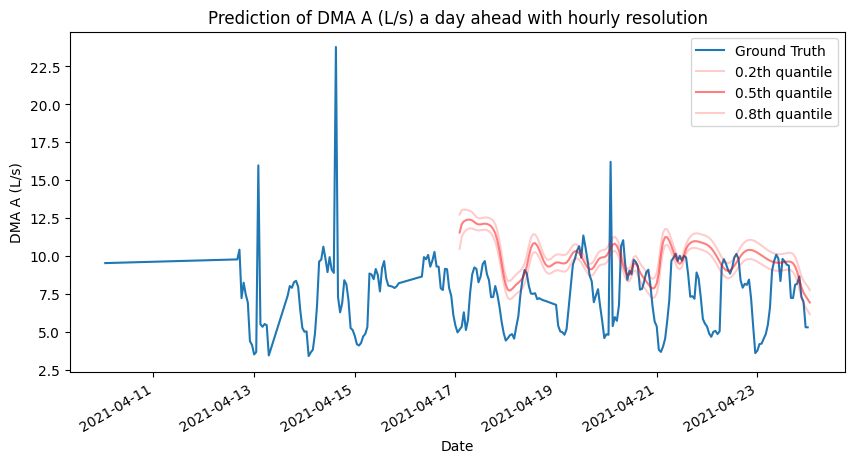

0.7
1.0
0.7


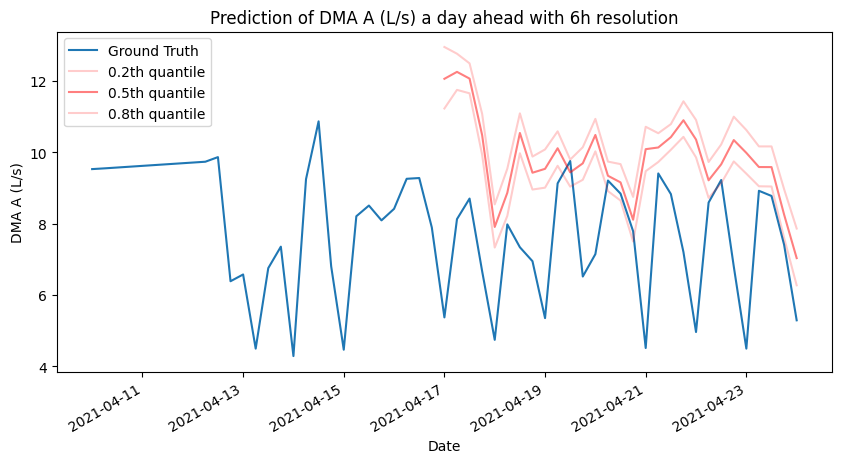

In [ ]:
# plot prediction along with prediction data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_truth.index, df_truth['DMA A (L/s)'], label='Ground Truth')
alpha = [quantile if quantile < 0.5 else 1-quantile for quantile in wandb.config['quantiles']]
for i, quantile in enumerate(wandb.config['quantiles']):
    df_prediction[f'Prediction {quantile}th quantile DMA A (L/s)'].plot(
        ax=ax, 
        color= 'red',
        alpha=alpha[i],
        label=f'{quantile}th quantile'
    )
ax.set_xlabel('Date')
ax.set_ylabel('DMA A (L/s)')
ax.legend()
ax.set_title('Prediction of DMA A (L/s) a day ahead with hourly resolution')
plt.show()

# resample above data to 6h resolution and plot again
df_truth_6h = df_truth.resample('6h').mean()
df_prediction_6h = df_prediction.resample('6h').mean()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_truth_6h.index, df_truth_6h['DMA A (L/s)'], label='Ground Truth')
alpha = [quantile if quantile < 0.5 else 1-quantile for quantile in wandb.config['quantiles']]
for i, quantile in enumerate(wandb.config['quantiles']):
    df_prediction_6h[f'Prediction {quantile}th quantile DMA A (L/s)'].plot(
        ax=ax, 
        color= 'red',
        alpha=alpha[i],
        label=f'{quantile}th quantile'
    )
ax.set_xlabel('Date')
ax.set_ylabel('DMA A (L/s)')
ax.legend()
ax.set_title('Prediction of DMA A (L/s) a day ahead with 6h resolution')
plt.show()


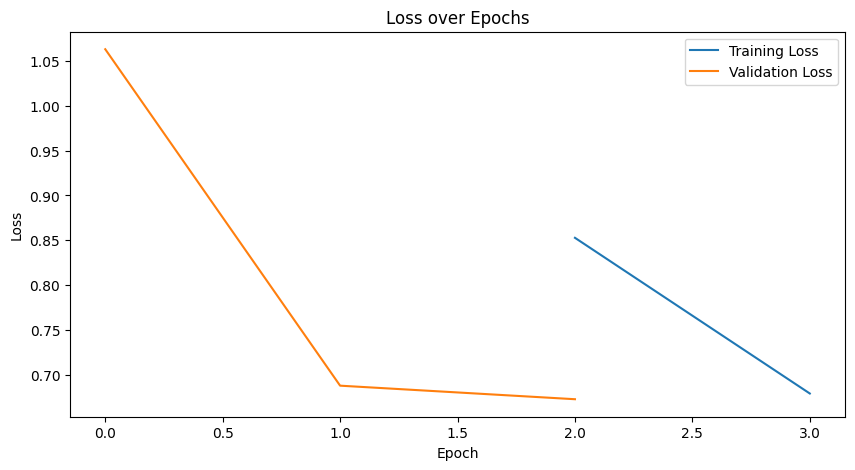

In [ ]:
# plot loss over epochs
# note that the first validation loss is an untrained loss and thus trained before the first epoch
# the first training loss is the loss after the first epoch
# model.train_losses
# model.val_losses

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, len(model.train_losses)+1), model.train_losses, label='Training Loss')
ax.plot(np.arange(0, len(model.val_losses)),model.val_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss over Epochs')
plt.show()

